# Active Learning GZ2 Bars for Paper

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [277]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid', {'font.size': '20.'})

In [208]:
from zoobot.active_learning.analysis import smooth_loss

In [209]:
!pwd

/Data/repos/zoobot/notebooks


In [210]:
def load_tensorboard_metric(results_dir, run_name, n_iterations, metric_name, eval_metric=False, frac=0.01):
    if eval_metric:
        locs = [os.path.join(results_dir, run_name + '_iteration_{}_estimators_eval-tag-{}.csv'.format(n_iterations, metric_name))]
    else:
        locs = [os.path.join(results_dir, run_name + '_iteration_{}_estimators-tag-{}.csv'.format(n, metric_name)) for n in range(n_iterations)]
    
    dfs = [pd.read_csv(loc, usecols=['Step', 'Value']) for loc in locs]

    for df_n, df in enumerate(dfs):
        smoothed_metric = sm.nonparametric.lowess(
            df['Value'],
            df['Step'],
            is_sorted=True, 
            frac=frac)  # controls how much smoothing
        df['smoothed_{}'.format(metric_name)] = smoothed_metric[:, 1]
        df['iteration'] = df_n
        
    flat_df = pd.concat(dfs)
    flat_df[metric_name] = flat_df['Value']
    flat_df['step'] = flat_df['Step']
    del flat_df['Value']
    del flat_df['Step'] 
    flat_df['run_name'] = run_name
    if 'active' in run_name:
        flat_df['acquisition'] = 'active'
    else:
        flat_df['acquisition'] = 'baseline'

    return flat_df

In [211]:
results_dir = '../results/active_learning_gz2_bars'

active_a_str = 'run_al_active_bar_4f6893_repeat'
active_b_str = 'run_al_active_bars_shuffled_zoomed_worked_4f68a93_probly'
baseline_a_str = 'run_al_baseline_500_500it_25_worked_4f68a93'
baseline_b_str = 'run_al_baseline'

### Visualise Train Loss

In [212]:
train_loss_frac = 0.15
active_a_train_df = load_tensorboard_metric(results_dir, active_a_str, 17, 'loss', frac=train_loss_frac)
active_b_train_df = load_tensorboard_metric(results_dir, active_b_str, 23, 'loss', frac=train_loss_frac)
baseline_a_train_df = load_tensorboard_metric(results_dir, baseline_a_str, 23, 'loss', frac=train_loss_frac)
baseline_b_train_df = load_tensorboard_metric(results_dir, baseline_b_str, 23, 'loss', frac=train_loss_frac)

In [213]:
train_loss_df = pd.concat([active_a_train_df, active_b_train_df, baseline_a_train_df, baseline_b_train_df]).sort_values('step').reset_index()

(10, 18)

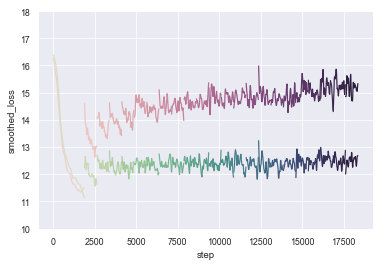

In [273]:
fig, ax = plt.subplots()
sns.lineplot(data=train_loss_df[train_loss_df['acquisition'] == 'active'], x='step', y='smoothed_loss', hue='iteration', legend=False, ci=None, ax=ax)
sns.lineplot(data=train_loss_df[train_loss_df['acquisition'] == 'baseline'], x='step', y='smoothed_loss', hue='iteration', legend=False, ci=None, palette=sns.cubehelix_palette(23, start=.5, rot=-.75), ax=ax)
ax.set_ylim([10, 18])

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(10, 18)

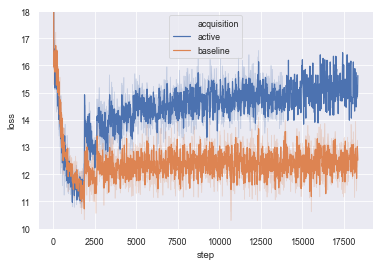

In [103]:
fig, ax = plt.subplots()
sns.lineplot(data=train_loss_df, x='step', y='loss', hue='acquisition', ax=ax)
ax.set_ylim([10, 18])

### Visualise Eval Loss

In [265]:
eval_loss_frac = 0.01
active_a_eval_df = load_tensorboard_metric(results_dir, active_a_str, 17, 'loss', eval_metric=True, frac=eval_loss_frac)
active_b_eval_df = load_tensorboard_metric(results_dir, active_b_str, 23, 'loss', eval_metric=True, frac=eval_loss_frac)
baseline_a_eval_df = load_tensorboard_metric(results_dir, baseline_a_str, 23, 'loss', eval_metric=True, frac=eval_loss_frac)
baseline_b_eval_df = load_tensorboard_metric(results_dir, baseline_b_str, 23, 'loss', eval_metric=True, frac=eval_loss_frac)

In [266]:
eval_loss_df = pd.concat([active_a_eval_df, active_b_eval_df, baseline_a_eval_df, baseline_b_eval_df]).sort_values('step').reset_index()
active_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'active'].groupby('step').agg('mean').reset_index()
baseline_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'baseline'].groupby('step').agg('mean').reset_index()

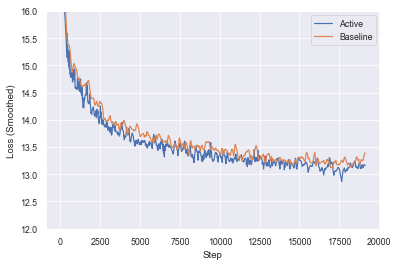

In [278]:
fig, ax = plt.subplots()
ax.plot(active_g['step'], active_g['smoothed_loss'], label='Active')
ax.plot(baseline_g['step'], baseline_g['smoothed_loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Smoothed)')
ax.set_ylim([12, 16])
ax.legend()

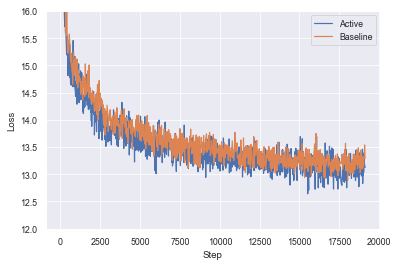

In [268]:
fig, ax = plt.subplots()
ax.plot(active_g['step'], active_g['loss'], label='Active')
ax.plot(baseline_g['step'], baseline_g['loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_ylim([12, 16])
ax.legend()

In [232]:
rmse_frac = 0.008
active_a_rmse_df = load_tensorboard_metric(results_dir, active_a_str, 17, 'rmse', eval_metric=True, frac=rmse_frac)
active_b_rmse_df = load_tensorboard_metric(results_dir, active_b_str, 23, 'rmse', eval_metric=True, frac=rmse_frac)
baseline_a_rmse_df = load_tensorboard_metric(results_dir, baseline_a_str, 23, 'rmse', eval_metric=True, frac=rmse_frac)
baseline_b_rmse_df = load_tensorboard_metric(results_dir, baseline_b_str, 23, 'rmse', eval_metric=True, frac=rmse_frac)
eval_rmse_df = pd.concat([active_a_rmse_df, active_b_rmse_df, baseline_a_rmse_df, baseline_b_rmse_df]).reset_index()

(0.14, 0.22)

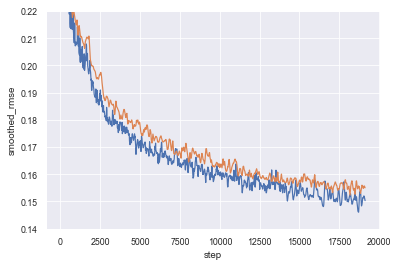

In [234]:
fig, ax = plt.subplots()
sns.lineplot(data=eval_rmse_df[eval_rmse_df['acquisition'] == 'active'], x='step', y='smoothed_rmse', ci=None, legend=False, ax=ax)
sns.lineplot(data=eval_rmse_df[eval_rmse_df['acquisition'] == 'baseline'], x='step', y='smoothed_rmse', ci=None, legend=False, ax=ax)
ax.set_ylim([.14, .22])

(0.14, 0.22)

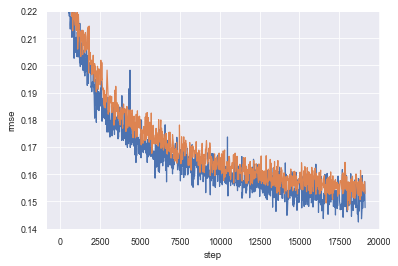

In [233]:
fig, ax = plt.subplots()
sns.lineplot(data=eval_rmse_df[eval_rmse_df['acquisition'] == 'active'], x='step', y='rmse', legend=False, ci=None, ax=ax)
sns.lineplot(data=eval_rmse_df[eval_rmse_df['acquisition'] == 'baseline'], x='step', y='rmse', legend=False, ci=None, ax=ax)
ax.set_ylim([.14, .22])